# Treatability scores

## Plain English summary

This notebook shows how to create a "treatability score" for a patient based on some of their characteristics. 

The method assumes that any XGBoost prediction or SHAP explainer models cannot be used directly. For example, we might not want to include a specific stroke team as required by those models, or we might be using a framework that makes it difficult or slow to access the models. 

Instead, we use the SHAP explainer to find average SHAP values for each possible value of each patient feature. When there are a small number of possible values, for example pre-stroke mRS from 0 to 5, a separate average SHAP is found for each. When there are a much larger number of possible values, for example onset-to-arrival time in minutes, the data is first grouped into smaller ranges of values and then the mean SHAP found across each range. This average SHAP value is the same for multiple patients with the same feature value and so this method gives more consistent results than from calculating new SHAP values from the explainer. 

The treatability scores are calculated by gathering each patient's SHAP value in each category from the average values, and then summing these multiple SHAP values. 

This notebook also shows an example of using the treatability scores when selecting a subset of patients to be treated. The patients with higher scores are more likely to be selected from the list, but it is still possible to select patients with lower scores.

## Sources

Data processing is copied from here: https://github.com/stroke-modelling/stroke-utilities/blob/main/docs/01_create_predictor_shap_and_benchmark_rankings.ipynb

Box plot creation is copied from here: https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

## Notebook setup:

In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt

import stroke_utilities.process_data as process_data

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import shap

import os
import pickle
import json

# .floor and .ceil
import math

# So can take deep copy
import copy

## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'

paths = Paths()

In [3]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '04'

## Import SHAP explainer

In [4]:
with open(f'{paths.model_folder}/shap_explainer.p', 'rb') as fp:
    explainer = pickle.load(fp)

## Load data

Import the data from file:

In [5]:
# Load data
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [6]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [7]:
test = test[features_to_model]

If the year of admission to stroke team is still in the data, restrict it to the following range.

Currently this process does nothing because we have already removed "year" from the data.

In [8]:
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [9]:
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [10]:
features = list(X_test)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model, we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [11]:
X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [12]:
# Get features
feature_names_ohe = list(X_test)

# Print the first several...
print(feature_names_ohe[:15])
# ... and last few feature names:
print(feature_names_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Create SHAP values for the test data: log-odds units

Pass the X_test data to the explainer object:

In [13]:
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)

## Setup for box plots

The code is copied from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

In [14]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)

features_shap_ranked = list(df_shap_values_mean.head(9).index)


df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)


,mean_shap,abs_mean_shap,mean_abs_shap,rank
infarction,-1.103923,1.103923,1.711107,1.0
stroke_severity,-0.102933,0.102933,0.927903,2.0
precise_onset_known,-0.035485,0.035485,0.502079,3.0
arrival_to_scan_time,-0.078830,0.078830,0.432781,4.0
prior_disability,0.000895,0.000895,0.395190,5.0
afib_anticoagulant,-0.049736,0.049736,0.393511,6.0
onset_to_arrival_time,-0.005894,0.005894,0.196703,7.0
age,-0.007623,0.007623,0.166250,8.0
onset_during_sleep,-0.009321,0.009321,0.092064,9.0
team_14,-0.002652,0.002652,0.030783,10.0


In [15]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

## Create box plots

The code is copied from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb with minor changes to collect the box plot values.

In [16]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)


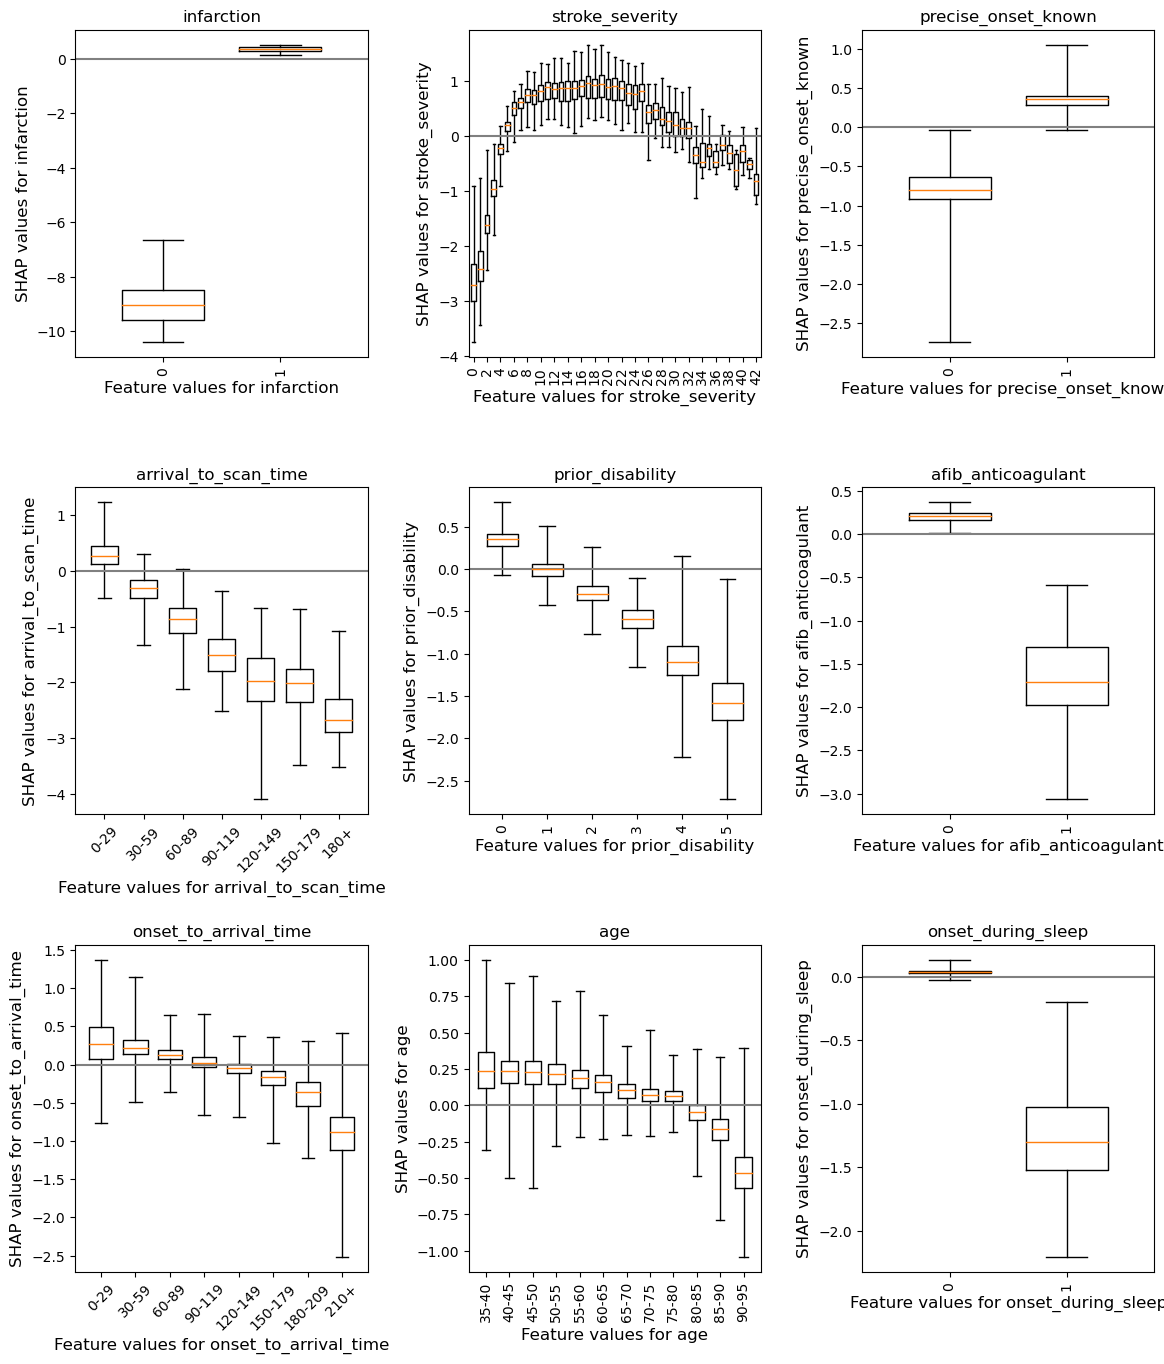

In [17]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

# Create figure
fig = plt.figure(figsize=(12,14), constrained_layout=True)
# A subplot showing violin plot for each feature.
# First prepare the fature data for the violin plot: if feature has more than 
# 50 unique values then assume it needs to be binned (a violin for each bin)

# Determine number of rows of subplots by rounding up
nrows = math.ceil(len(features_shap_ranked)/4)

# Through each feature
boxplot_dicts = {}
bin_dicts = {}
category_dicts = {}
for n, feat in enumerate(features_shap_ranked):    
    
    # Get data adn SHAP values
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # If feature has more that 50 unique values, then assume it needs to be 
    # binned (otherwise assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != "age":
            category_list = [int(i) for i in category_list]

        # Add this for return:
        bin_list = category_list

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # # Output descriptive text to use in the paper to describe the differences a 
    # # feature value had on the likelihood of receiving thromboylsis.
    # if feat == "infarction":
    #     range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke type: The SHAP values for stroke type show that the \n"
    #           f"model effectively eliminated any probability of receiving \n"
    #           f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
    #           f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
    #           f"fold.\n")    
    # if feat == "arrival_to_scan_time":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[3])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
    #     f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    # if feat == "stroke_severity":
    #     range_shap_log_odds = np.mean(shap_per_category[19]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
    #       f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
    #       f"with higher stroke severity (NIHSS above 25). The difference between \n"
    #       f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
    #       f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    # if feat == "precise_onset_known":
    #     range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
    #       f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
    #       f"estimated onset time.\n")
    # if feat == "prior_disability":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[5])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Disability level (mRS) before stroke: The odds of receiving \n"
    #     f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    # if feat == "afib_anticoagulant":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
    #     f" {round(odds,2)} fold greater for no use.\n")
    # if feat == "onset_to_arrival_time":
    #     range_shap_log_odds = np.mean(shap_per_category[4]) - np.mean(shap_per_category[7])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
    #     f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    # if feat == "age":
    #     range_shap_log_odds = np.mean(shap_per_category[13]) - np.mean(shap_per_category[17])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
    #     f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    # if feat == "onset_during_sleep":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
    #     f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == "age":
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). To accommodate this, if last age category is "110"
        #   then overwrite the label with the correct band (100-120), and not
        #   107-112 as the above code would create.
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
            
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    boxplot_dict = ax.boxplot(shap_per_category, whis=99999, widths=0.7)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == "stroke_severity":
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)

    boxplot_dicts[feat] = boxplot_dict
    bin_dicts[feat] = bin_list
    category_dicts[feat] = category_list
    
plt.tight_layout(pad=2)
    
fig.savefig(f'stroke_utilities/output/{notebook}_{model_text}_thrombolysis_shap_boxplot_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()



## Extract data from the box plots

We store the edges of the bins in `bin_dicts`:

In [18]:
bin_dicts['onset_to_arrival_time']

[0, 30, 60, 90, 120, 150, 180, 210, 254.0]

And we store the names of each bin from the x-axis in `category_dicts`:

In [19]:
category_dicts['onset_to_arrival_time']

['0-29', '30-59', '60-89', '90-119', '120-149', '150-179', '180-209', '210+']

We extract all of the median SHAP values from the box plots and place it in `median_dicts`:

In [20]:
median_dicts = {}
for key in boxplot_dicts.keys():
    median_lines = boxplot_dicts[key]['medians']
    meds = []
    for i, line in enumerate(median_lines):
        med = line.get_ydata()[0]
        meds.append(med)
    median_dicts[key] = meds

For each feature, there is one median value for each range of values with its own box plot.

In [21]:
print('Feature' + ' '*17 + 'Number of values\n' + '-'*40) 
for key in median_dicts.keys():
    print(f'{key:30}', f'       {len(median_dicts[key]):2}')

Feature                 Number of values
----------------------------------------
infarction                             2
stroke_severity                       43
precise_onset_known                    2
arrival_to_scan_time                   7
prior_disability                       6
afib_anticoagulant                     2
onset_to_arrival_time                  8
age                                   12
onset_during_sleep                     2


## Find which bins each patient's data falls into

In [22]:
def collect_mean_shaps_for_patient(patient_data, bin_dicts, shap_dicts):
    """

    If we end up using this often, change the function to expect patient_data to be a 2D array
    and "val" to be a column of data for multiple patients. np.digitize can take array input.
    Then update the bin ranges as bin[these bits] = this_value.
    
    """
    shap_values_for_patient = {}
    for key in bin_dicts.keys():
        # Bins for this category:
        bins = bin_dicts[key]
        shaps = shap_dicts[key]
        # Value of this category for this patient:
        val = patient_data[key]
        # Bin this falls into:
        bin = np.digitize(val, bins) - 1
        # Sort out values outside the bin ranges:
        bin = 0 if bin < 0 else bin
        # For the time categories, the length of bins is one more
        # than the length of shaps. So make sure the value can
        # be accessed by using the last shaps bin, not the last 
        # bins bin.
        bin = -1 if bin == len(shaps) else bin
        # SHAP value for this bin:
        shap = shaps[bin]
        # Store in list:
        shap_values_for_patient[key] = shap
    return shap_values_for_patient

Look up median shap values for all patients.

In [23]:
all_patient_shap_values = []
for p in range(len(X_test)):
    this_patient_data = X_test.loc[p]
    shap_values_for_patient = collect_mean_shaps_for_patient(
        this_patient_data, bin_dicts, median_dicts)
    # Convert dict to series:
    shap_values_for_patient = pd.Series(
        shap_values_for_patient.values(), shap_values_for_patient.keys())
    all_patient_shap_values.append(shap_values_for_patient)

Convert all of those dictionaries to a single dataframe:

In [24]:
df_all_patient_shap_values = pd.DataFrame(all_patient_shap_values)

Sum the SHAP values for all patients

In [25]:
df_all_patient_shap_values['treatability_score'] = (
    df_all_patient_shap_values.sum(axis=1))

Show the first five patients' values:

In [26]:
df_all_patient_shap_values.head(5).T

,0,1,2,3,4
infarction,0.353629,0.353629,0.353629,0.353629,-9.035469
stroke_severity,0.824566,0.870072,0.870072,-1.621984,-0.972790
precise_onset_known,0.362444,0.362444,0.362444,-0.794324,0.362444
arrival_to_scan_time,0.274701,0.274701,0.274701,-0.871277,0.274701
prior_disability,-0.289691,-0.005011,-1.094147,-0.005011,0.357452
afib_anticoagulant,0.205136,0.205136,0.205136,0.205136,-1.715489
onset_to_arrival_time,0.129469,0.215359,0.026407,0.129469,0.026407
age,0.213782,0.064194,-0.045162,0.073785,-0.164092
onset_during_sleep,0.036071,0.036071,0.036071,-1.303942,0.036071
treatability_score,2.110106,2.376594,0.989150,-3.834520,-10.830767


## Compare treatability score with real-life treatment decision

The original patient data includes whether the patients received thrombolysis. We can see whether a higher treatability score means a patient is more likely to receive thrombolysis.

Create masks of whether or not patients received thrombolysis:

In [27]:
mask_thrombolysed = (y_test == 1)
mask_not_thrombolysed = (y_test != 1)

Create bins for the treatability scores:

In [28]:
# Step between bins:
step = 0.5

# Bins with this step and a range spanning all scores:
hist_bins = step * np.arange(
    df_all_patient_shap_values['treatability_score'].min() // step,
    2.0 + (df_all_patient_shap_values['treatability_score'].max() // step),
    1
    ) - (0.5 * step)
# The final  - (0.5 * step) is included so that the middle of the bins
# are multiples of step.

Bin sanity check:

In [29]:
print(hist_bins[:3])
print(min(hist_bins), max(hist_bins), len(hist_bins))
print(f'{df_all_patient_shap_values["treatability_score"].min():.3f}', 
      f'{df_all_patient_shap_values["treatability_score"].max():.3f}')

[-16.75 -16.25 -15.75]
-16.75 3.25 41
-16.323 3.003


Plot the number of patients in each score bin, split by whether they were treated:

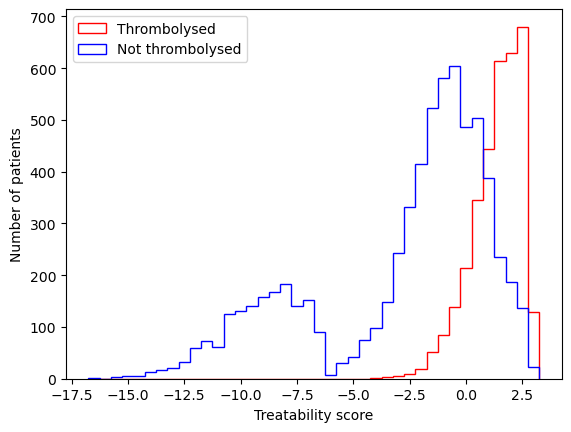

In [30]:
fig, ax = plt.subplots()

n_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['treatability_score'][mask_thrombolysed], 
    bins=hist_bins, color='r', histtype='step', label='Thrombolysed')
n_not_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['treatability_score'][mask_not_thrombolysed], 
    bins=hist_bins, color='b', histtype='step', label='Not thrombolysed')

ax.set_xlabel('Treatability score')
ax.set_ylabel('Number of patients')
ax.legend()
plt.show()

In this graph, the second peak below a treatability score of around minus 7 is due to the large negative SHAP value when infarction is "yes". This value is around minus 9:

In [31]:
median_dicts['infarction']

[-9.035469055175781, 0.35362885892391205]

## Convert to percentage thrombolysed

The above histograms' outputs include the number of patients in each score bin. Use these to calculate the percentage of patients in each bin that were treated:

In [32]:
perc_thrombolysed = 100.0 * n_thrombolysed / (n_thrombolysed + n_not_thrombolysed)

For this plot, use the centre of each bin rather than the edges:

In [33]:
hist_bins_mean = 0.5 * (hist_bins[:-1] +  hist_bins[1:])

For comparing the data with a model, create a function that calculates the percentage treated by assuming that this value varies with increasing treatability score in the form of an expit function (a.k.a. a logistic sigmoid, the same as we use for mRS probability distributions varying with time). 

In [34]:
from scipy.special import expit

In [35]:
def calculate_model_treatment_probability(x, x_50perc):
    # 100 * is for y-scale from range 0 to +1 to 0 to +100.
    # Within expit, -x_50perc is for x-offset from centred on x=0 to x=x_50perc.
    y_model = 100.0 * expit(x - x_50perc)
    return y_model

Plot the data with the model:

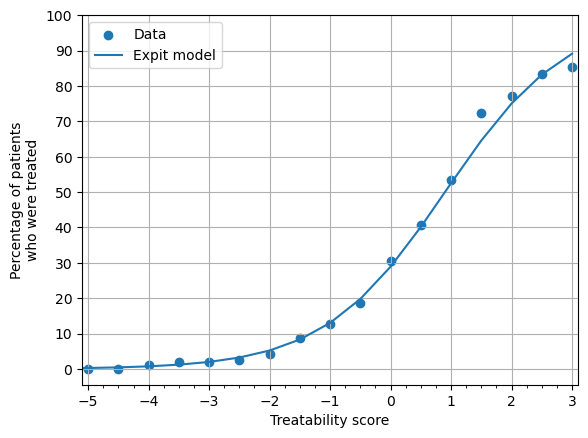

In [36]:
fig, ax = plt.subplots()

# Treatability score that gives 50% on the y-axis:
x_50perc = 0.9  # eyeballed
# Define y-coordinates for a model line.
y_model = calculate_model_treatment_probability(hist_bins_mean, x_50perc)
# Data:
ax.scatter(hist_bins_mean, perc_thrombolysed, label='Data')
# Model:
ax.plot(hist_bins_mean, y_model, label='Expit model')

# Graph setup:
ax.set_xlim(-5.1, 3.1)
ax.set_xticks(np.arange(-5.0, 3.0, 0.25), minor=True)
ax.set_yticks(np.arange(0.0, 100.1, 10))
ax.grid()

ax.set_xlabel('Treatability score')
ax.set_ylabel('Percentage of patients\nwho were treated')
ax.legend()

plt.show()

View data points from the chart:

In [37]:
pd.DataFrame([hist_bins_mean, perc_thrombolysed]).T

,0,1
0,-16.5,0.000000
1,-16.0,NaN
2,-15.5,0.000000
3,-15.0,0.000000
4,-14.5,0.000000
5,-14.0,0.000000
6,-13.5,0.000000
7,-13.0,0.000000
8,-12.5,0.000000
9,-12.0,0.000000


## Convert scores to chance of being picked by np.choice

Use the model to convert each patient's treatability score into a probability of treatment:

In [38]:
all_model_treatability = calculate_model_treatment_probability(
    df_all_patient_shap_values['treatability_score'], x_50perc)

Place this new data into the existing SHAP value data frame:

In [39]:
df_all_patient_shap_values['treatability_percentage_(model)'] = all_model_treatability

In [40]:
df_all_patient_shap_values.head(5).T

,0,1,2,3,4
infarction,0.353629,0.353629,0.353629,0.353629,-9.035469
stroke_severity,0.824566,0.870072,0.870072,-1.621984,-0.972790
precise_onset_known,0.362444,0.362444,0.362444,-0.794324,0.362444
arrival_to_scan_time,0.274701,0.274701,0.274701,-0.871277,0.274701
prior_disability,-0.289691,-0.005011,-1.094147,-0.005011,0.357452
afib_anticoagulant,0.205136,0.205136,0.205136,0.205136,-1.715489
onset_to_arrival_time,0.129469,0.215359,0.026407,0.129469,0.026407
age,0.213782,0.064194,-0.045162,0.073785,-0.164092
onset_during_sleep,0.036071,0.036071,0.036071,-1.303942,0.036071
treatability_score,2.110106,2.376594,0.989150,-3.834520,-10.830767


Take the first 1000 patients in the list.

In [41]:
n_subset = 1000

In [42]:
df_treatability = pd.DataFrame()
df_treatability['treatability_percentage_(model)'] = df_all_patient_shap_values['treatability_percentage_(model)'][:n_subset]

Normalise and divide by sum to get a series of values that add to one:

In [43]:
# Rename the array for easier reading:
modelled_treatability_percs = df_treatability['treatability_percentage_(model)']

# Normalise:
modelled_treatability_norm = (
    (modelled_treatability_percs - modelled_treatability_percs.min()) / 
    (modelled_treatability_percs.max() - modelled_treatability_percs.min())
    )

# Divide by sum:
modelled_treatability_relative_chance = (
    modelled_treatability_norm / modelled_treatability_norm.sum())

# Store in dataframe:
df_treatability['relative_chance'] = modelled_treatability_relative_chance

Also rank the patients in order of likeliness of being treated:

In [44]:
df_treatability = df_treatability.sort_values('treatability_percentage_(model)', ascending=False)

df_treatability['rank'] = np.arange(len(df_treatability))

View the dataframe:

In [45]:
df_treatability

,treatability_percentage_(model),relative_chance,rank
862,88.186024,2.618511e-03,0
260,88.037519,2.614101e-03,1
319,87.679185,2.603461e-03,2
972,87.568758,2.600182e-03,3
318,87.350270,2.593695e-03,4
...,...,...,...
554,0.000091,2.337060e-09,995
498,0.000039,7.929249e-10,996
613,0.000027,4.215234e-10,997
74,0.000019,1.975676e-10,998


A minor limitation of this method is that the final patient in the list has a 0% chance of being picked.

## Run trials of selecting patients for treatment

Run several trials of picking out 100 patients (10%) and see how this compares with their treatability score.

In [46]:
n_picked = 100
n_trials = 10

We'll select patients using their index values from the dataframe:

In [47]:
inds = modelled_treatability_relative_chance.index.values

The following cell runs the trials. The method is:

1. Use `np.choice` to select patients. The values selected are the index values of the DataFrame. The probability of being selected is not the same for all patients, but instead we weight the likeliness of being selected using the `relative_chance` calculated earlier.
2. Create boolean array to keep track of whether patients were picked.
3. Plot histograms of the picked patients' treatability percentages and their ranks in the ordered list of likeliness of being picked.

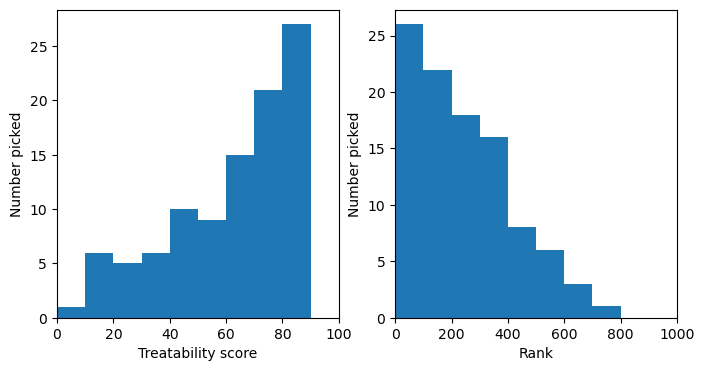

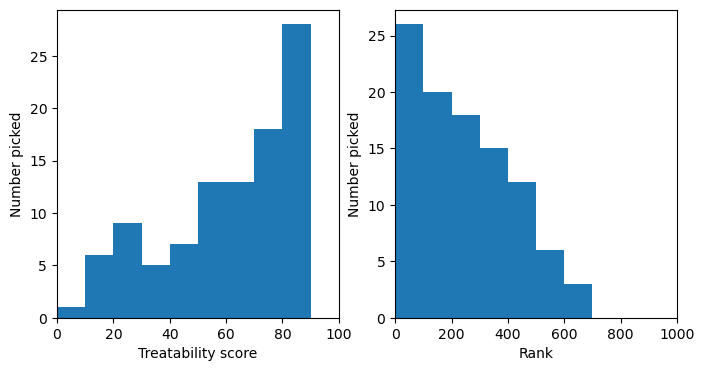

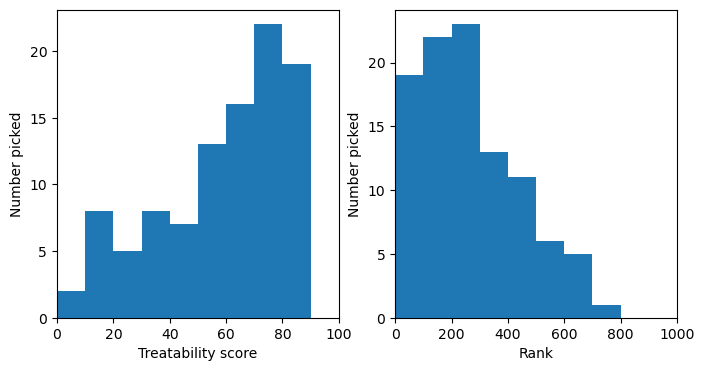

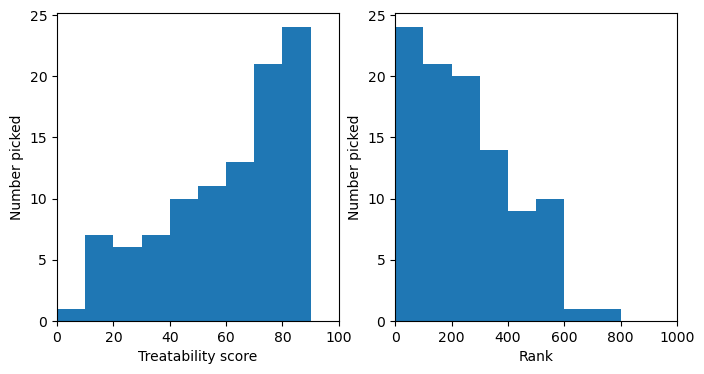

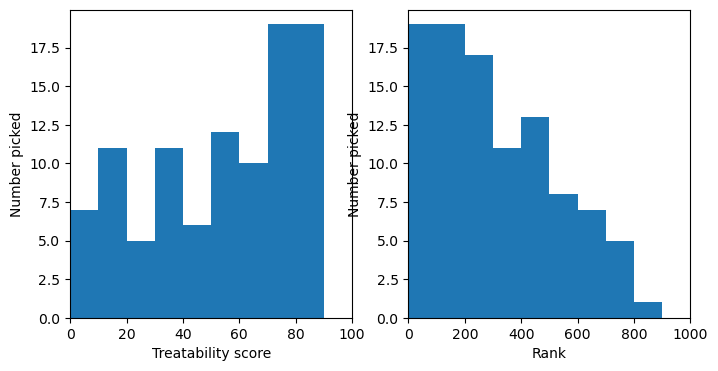

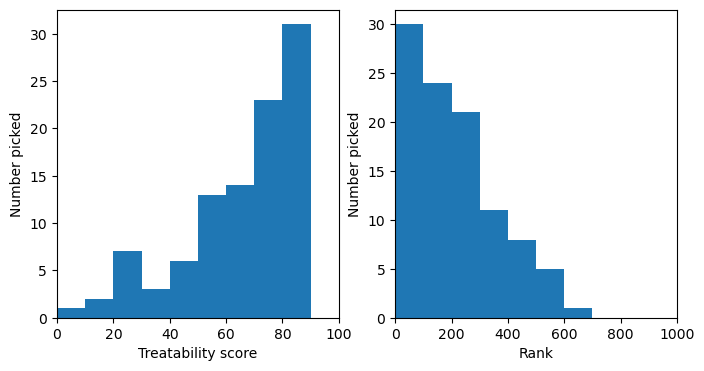

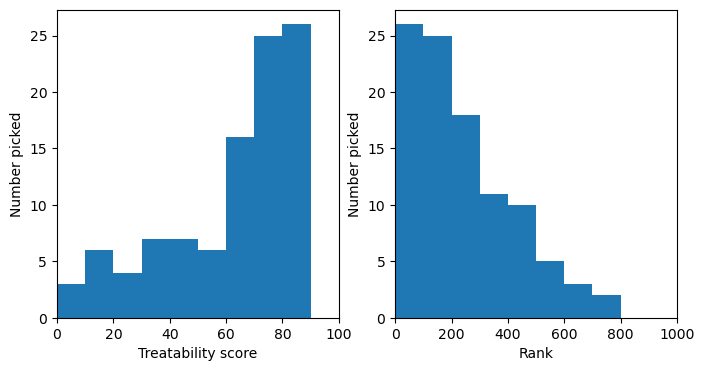

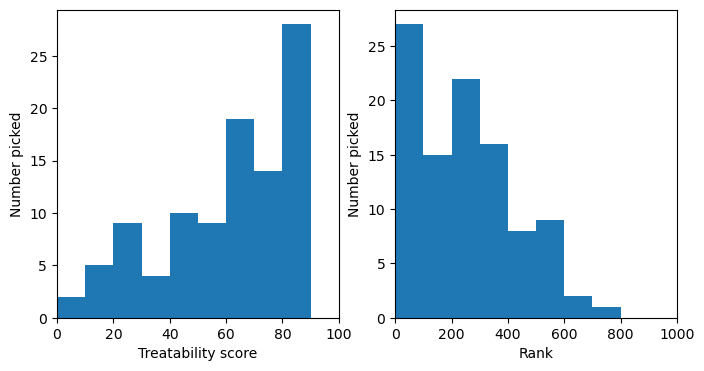

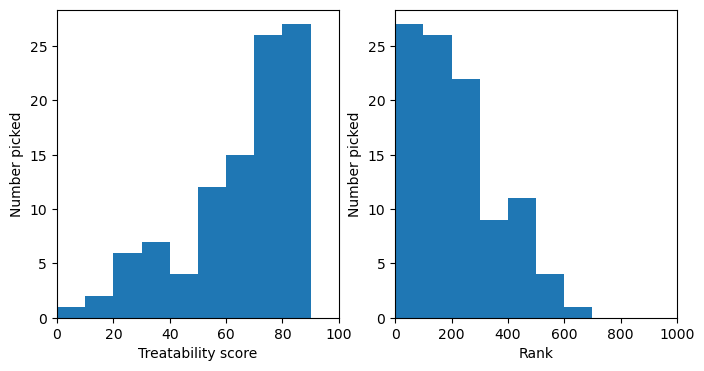

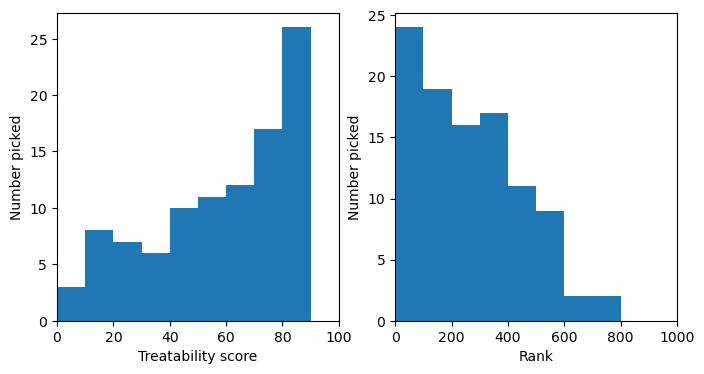

In [48]:
np.random.seed(42)

for t in range(n_trials):
    # Find indices of the selected patients.
    picked_patients = np.random.choice(
        inds, size=n_picked, replace=False, p=df_treatability['relative_chance'])

    # Create boolean array to track whether patients were picked.
    picked_bool = np.full(inds.shape, 0)
    picked_bool[picked_patients] = 1

    # Create bins to place the picked patients' values into
    # so that the histgorams are consistent across trials.
    treatability_hist_bins = np.arange(0.0, 100.1, 10)
    rank_hist_bins = np.arange(0, n_subset, 0.1*n_subset)

    # Plot the results.
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].hist(
        df_treatability['treatability_percentage_(model)'][picked_bool == 1],
        bins=treatability_hist_bins
        )
    axs[1].hist(df_treatability['rank'][picked_bool == 1], 
                bins=rank_hist_bins)

    axs[0].set_xlabel('Treatability score')
    axs[0].set_ylabel('Number picked')
    axs[1].set_xlabel('Rank')
    axs[1].set_ylabel('Number picked')

    axs[0].set_xlim(0, 100)
    axs[1].set_xlim(0, 1000)
    plt.show()
    plt.close()

Most of the patients picked have higher treatability scores and so lower ranks in the list. However, the spread of patients is greater than only picking the top 100 most treatable would have been.